# **Tensorflow ile Öğrenmeyi Aktarmak - Özellik Çıkarımı**

**İçindekiler**
```
1. Transfer öğrenme nedir?
2. Tensorflow Hub ile örnek çalışma
  2.1. Verilerin içeri aktarımı
  2.2. Verilerin ön hazırlığı
  2.3. Geri arama ekleme
  2.4. Tensorflow Hub ile model oluşturma
  2.5. Kayıp eğrisi grafiği oluşturma
  2.6. Yeni bir model daha oluşturma
3. Tensorboard
4. Kaynakça
```

In [ ]:
import datetime
print(f"Bu kitabın son çalışma tarihi: {datetime.datetime.now()}")

Bu kitabın son çalışma tarihi: 2024-12-04 14:32:05.149318


In [ ]:
# GPU kullanıyor muyuz?
!nvidia-smi

Wed Dec  4 14:32:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Bazı kütüphanelerin içeri aktarımı
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# **1. Transfer öğrenme nedir?**

Model(ler)imizi geliştirmek için, farklı konfigürasyonları denemek, daha fazla katman eklemek, öğrenme oranını değiştirmek, katman başına nöron sayısını ayarlamak ve daha fazlasını yapmak için biraz zaman harcayabiliriz. Ama bu çok zaman alıcıdır.

Daha kolay bir yolu olan ***transfer öğrenmesi***, başka bir modelin bir problemden öğrendiği kalıpları (ağırlıklar olarak da adlandırılır) ve yapısını kendi sorunumuz için kullanmaktır.

* Bizimkine benzer sorunlar üzerinde çalıştığı kanıtlanmış mevcut bir sinir ağı mimarisinden yararlanabilir.
* Bizimkine benzer veriler üzerinde kalıpları zaten öğrenmiş olan çalışan bir sinir ağı mimarisinden yararlanabilir. Bu genellikle daha az özel veri ile mükemmel sonuçlar elde etmenizle sonuçlanır.

Kendi modellerimizi kendi veri kümelerimizde sıfırdan eğitmek yerine, bir modelin öğrendiği kalıpları ImageNet (farklı nesnelerin milyonlarca görüntüsü) gibi veri kümelerinden alabilir ve bunları kendi temelimiz olarak kullanabiliriz. Bunu yapmak genellikle daha az veri ile harika sonuçlar elde etmeye yol açar.

***Bazı eğitim harici bilgiler;***
* shift + smd + space --> docstring
* EfficientNet --> en gelişmiş bilgisayarlı görme mimarilerinden birisidir https://www.image-net.org/

# **2. Tensorflow Hub ile örnek çalışma**

TensorFlow Hub, mevcut model bileşenleri için bir depodur. Bir URL kadar az tam eğitimli bir modeli içe aktarabilmeniz ve kullanabilmeniz için yapar.

https://www.kaggle.com/models?tfhub-redirect=true

Hızlı deneme için, orijinal verilerin yalnızca %10'u ile iyi sonuçlar elde etmeye çalışacağız

Genellikle daha çok veri ile daha iyi sonuçlar elde edilir. Ama yeterli sayıda veri yoksa transfer öğrenme mantıklıdır.

### **2.1. Verilerin içeri aktarımı**

In [1]:
# 10 gıda sınıfı veri setinin %10'unu içeren bir veri setini içeri aktarma
import zipfile

# Veriyi yükle
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Yüklenen verileri aç
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2024-12-06 18:15:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   115MB/s    in 1.4s    

2024-12-06 18:15:28 (115 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Her bir dosyada kaç veri var?
import os

# Yüzde 10 veri dizinini inceleyin ve dosya sayısını listeleyin
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"'{dirpath}' dizininde {len(dirnames)} dizin ve {len(filenames)} resim var'.")

'10_food_classes_10_percent' dizininde 2 dizin ve 0 resim var'.
'10_food_classes_10_percent/train' dizininde 10 dizin ve 0 resim var'.
'10_food_classes_10_percent/train/steak' dizininde 0 dizin ve 75 resim var'.
'10_food_classes_10_percent/train/ramen' dizininde 0 dizin ve 75 resim var'.
'10_food_classes_10_percent/train/chicken_wings' dizininde 0 dizin ve 75 resim var'.
'10_food_classes_10_percent/train/chicken_curry' dizininde 0 dizin ve 75 resim var'.
'10_food_classes_10_percent/train/hamburger' dizininde 0 dizin ve 75 resim var'.
'10_food_classes_10_percent/train/ice_cream' dizininde 0 dizin ve 75 resim var'.
'10_food_classes_10_percent/train/pizza' dizininde 0 dizin ve 75 resim var'.
'10_food_classes_10_percent/train/fried_rice' dizininde 0 dizin ve 75 resim var'.
'10_food_classes_10_percent/train/sushi' dizininde 0 dizin ve 75 resim var'.
'10_food_classes_10_percent/train/grilled_salmon' dizininde 0 dizin ve 75 resim var'.
'10_food_classes_10_percent/test' dizininde 10 dizin ve 0

Eğitim dizinlerinin her birinin artık 750 görüntü yerine 75 görüntüye sahip olduğuna dikkat edin. Bu, transfer öğrenmesinin daha az etiketli görüntülerle ne kadar iyi performans gösterebileceğini göstermenin anahtarıdır.

Test dizinlerinde hala aynı miktarda görüntü var. Bu, daha az veri üzerinde eğitim alacağımız, ancak modellerimizi aynı miktarda test verisi üzerinde değerlendireceğimiz anlamına gelir.

`os.walk()` fonksiyonu, verilen dizin yolundaki tüm alt dizinleri ve dosyaları gezmek için kullanılan bir fonksiyondur. Bu fonksiyon üç öğe döndürür:
- `dirpath`: Mevcut dizinin tam yolu (yani, şu anda bakmakta olduğumuz dizin).
- `dirnames`: O dizin altındaki tüm alt dizinlerin isimlerinin bir listesi.
- `filenames`: O dizin altındaki tüm dosyaların isimlerinin bir listesi.

Bu fonksiyon, her bir alt dizini ve dosyayı gezerek birer birer işlem yapmanızı sağlar.

**`for` Döngüsü ile İterasyon**
Bu kodda, `os.walk()` fonksiyonu ile "10_food_classes_10_percent" dizini altındaki tüm dizinler ve dosyalar üzerinde döngü kuruluyor.

In [3]:
import os
import pandas as pd

def get_image_counts(base_dir):
    # Sonuçları tutmak için bir liste
    data = []

    # 'train' ve 'test' dizinlerini gez
    for split in ['train', 'test']:
        split_path = os.path.join(base_dir, split)

        # 'train' veya 'test' içinde her bir gıda sınıfı dizinini gez
        for class_dir in os.listdir(split_path):
            class_path = os.path.join(split_path, class_dir)

            # Eğer bu bir dizinse (gıda sınıfı klasörü)
            if os.path.isdir(class_path):
                # O dizindeki resim dosyalarının sayısını hesapla
                image_count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])

                # Veriyi ekle
                data.append([split, class_dir, image_count])

    # Pandas DataFrame ile tablomuzu oluştur
    df = pd.DataFrame(data, columns=["Veri Seti", "Sınıf", "Resim Sayısı"])

    return df

# Fonksiyonu çağır ve tabloyu yazdır
base_dir = "10_food_classes_10_percent"  # Veri setinin bulunduğu ana dizin
image_counts_df = get_image_counts(base_dir)
print(image_counts_df)

   Veri Seti           Sınıf  Resim Sayısı
0      train      fried_rice            75
1      train  grilled_salmon            75
2      train           ramen            75
3      train   chicken_wings            75
4      train           sushi            75
5      train       ice_cream            75
6      train   chicken_curry            75
7      train           pizza            75
8      train       hamburger            75
9      train           steak            75
10      test      fried_rice           250
11      test  grilled_salmon           250
12      test           ramen           250
13      test   chicken_wings           250
14      test           sushi           250
15      test       ice_cream           250
16      test   chicken_curry           250
17      test           pizza           250
18      test       hamburger           250
19      test           steak           250


### **2.2. Verilerin ön hazırlığı**

Görüntülerimize yüklemek için flow_from_directory yöntemiyle birlikte ImageDataGenerator sınıfını kullanalım.

Aşağısı için;
* image_shape ve batch_size burada hiper parametredir.
* class_mode neden kategorik? İkili veya çoklu sınıflandırmada olan bir durum.
* Artık test verileri önceki not defterinde kullandığımız test setinin tamamen aynısıdır. Yani daha az eğitim görseli olmasına rağmen, tamamen aynı test görselleri var, aynı miktarda.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Eğitim Görüntüleri:")
train_data_10_percent = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

print("Test Görüntüleri:")
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Eğitim Görüntüleri:
Found 750 images belonging to 10 classes.
Test Görüntüleri:
Found 2500 images belonging to 10 classes.


`train_datagen` ve `test_datagen` nesneleri, veri artırma (data augmentation) ve veri ön işleme işlemlerinde kullanılır. Ancak, eğitim ve test verilerinin işlenişi farklıdır.

- **Eğitim Verisi (`train_datagen`)**: Genellikle eğitim sırasında veri artırma (data augmentation) işlemleri yapılır. Bu, modelin daha çeşitli ve genelleştirilmiş bir şekilde öğrenmesine yardımcı olur. Veri artırma, resimleri döndürme, yansıtma, kırpma veya renk değişimleri gibi rastgele işlemler yaparak modelin overfitting (aşırı uyum) yapmasını engeller. Fakat burada sadece `rescale=1/255.` işlemi yapılmış, yani verilerin her piksel değerini 0 ile 1 arasına ölçeklendiriyoruz. Bu, modelin daha iyi öğrenmesini sağlamak için yapılan temel bir ön işleme adımıdır.

- **Test Verisi (`test_datagen`)**: Test verisi, eğitim sırasında yapılan veri artırma işlemlerine tabi tutulmaz. Çünkü test verisinin amacı, modelin gerçek dünya verileri üzerinde ne kadar iyi performans gösterdiğini değerlendirmektir. Test verisini olduğu gibi kullanmalıyız; yalnızca gerekli normalizasyon işlemi yapılır (bu durumda `rescale=1/255.`). Veri artırma kullanmak test setinde yanıltıcı olabilir.

---

- **Resimlerin yüklenmesi**: `flow_from_directory` fonksiyonu, belirtilen dizindeki (klasördeki) görselleri yükler ve belirli bir boyutta (`target_size=IMAGE_SHAPE`) yeniden boyutlandırır. Bu örnekte resimler 224x224 boyutuna dönüştürülüyor.
  
- **Normalizasyon (Rescale)**: Görsellerin piksel değerleri 0 ile 255 arasında olabilir. Bu kodda her bir piksel değeri `1/255` ile bölünerek 0 ile 1 arasına ölçeklendiriliyor. Bu, modelin daha verimli öğrenmesini sağlar çünkü genellikle sinir ağları düşük değerlerle (0-1 arasında) daha stabil çalışır.

- **Sınıflandırma Etiketleri**: Resimler, belirtilen dizin yapısına göre etiketlenir. Her alt klasör, bir sınıfı temsil eder ve bu sınıflar için etiketler otomatik olarak oluşturulur. Bu etiketler kategorik (one-hot encoded) formatında verilir.

- **Batch ve veri akışı**: `flow_from_directory` fonksiyonu, verilerin batch (küme) halinde okunmasını sağlar. Bu, özellikle büyük veri kümeleri ile çalışırken belleği daha verimli kullanmak için önemlidir.

---

`class_mode="categorical"` parametresi, etiketlerin **kategorik** formatta verileceğini belirtir. Bu, **çok sınıflı sınıflandırma (multi-class classification)** problemleri için yaygın bir yaklaşımdır. Burada `class_mode="categorical"` demek, her sınıfın bir **one-hot encoded** vektörü ile temsil edileceği anlamına gelir.

Örneğin, 10 sınıf varsa, bir etiket aşağıdaki gibi olacak:
- Eğer bir örnek "pizza" sınıfına aitse ve pizza 3. sınıf ise etiket şu şekilde olur: `[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]`.

Bu, modelin her örneğin ait olduğu sınıfı doğru şekilde öğrenmesini sağlamak için kullanılır. Modelin çıktısı da bir **softmax** aktivasyon fonksiyonu kullanarak her sınıf için bir olasılık değeri verir ve en yüksek olasılık değeri, modelin tahmin ettiği sınıf olur.

### **2.3. Geri arama ekleme**

Geri aramalar, eğitim sırasında veya sonrasında gerçekleştirilecek modellerinize ekleyebileceğiniz ekstra işlevselliktir. En popüler geri aramalardan bazıları şunları içerir:

* TensorBoard ile deneme izleme - birden fazla modelin performansını günlüğe kaydedin ve ardından bu modelleri TensorBoard'da (sinir ağı parametrelerini incelemek için bir gösterge paneli) görsel bir şekilde görüntüleyin ve karşılaştırın. Verilerinizdeki farklı modellerin sonuçlarını karşılaştırmak için yararlıdır.

* Model kontrol noktası - modelinizi eğitilirken kaydedin, böylece gerekirse eğitimi durdurabilir ve bıraktığınız yerden devam etmek için geri dönebilirsiniz. Eğitim uzun sürerse ve bir oturuşta yapılamazsa yardımcı olur.

* Erken durdurma - model eğitiminizi keyfi bir süre için bırakın ve gelişmeyi bıraktığında eğitimi otomatik olarak durdurmasını sağlayın. Büyük bir veri kümeniz olduğunda ve eğitimin ne kadar süreceğini bilmiyorsanız yardımcı olur.

TensorBoard geri çağrısına tf.keras.callbacks.TensorBoard() kullanılarak erişilebilir.

Ana işlevi, bir modelin eğitim performans metriklerini belirli bir log_dir'e kaydetmektir.

Varsayılan olarak, günlükler her çağda update_freq='epoch' parametresi kullanılarak kaydedilir. Model performansını çok sık izlemek model eğitimini yavaşlatabileceğinden, bu iyi bir varsayılandır.

🔑 Not: TensorBoard geri araması oluşturmak için bir işlev oluşturuyoruz, çünkü daha sonra göreceğimiz gibi, her modelin kendi TensorBoard geri arama örneğine ihtiyacı vardır (bu nedenle işlev her çalıştırıldığında yeni bir tane oluşturacaktır).

* https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
* https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
* https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
* https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

Birden fazla deney yapacağınız için, onları bir şekilde takip edebilmek iyi bir fikirdir.

Bizim durumumuzda, işlevimiz bir modelin performans günlüklerini [dir_name]/[experiment_name]/[current_timestamp] adlı bir dizine kaydeder, burada:

* Dir_name genel günlükler dizinidir

* Experiment_name özel deneydir

* Current_timestamp, Python'un datetime.datetime().now() dosyasına göre deneyin başladığı zamandır. Model çalıştığı zaman tarih ve zaman damgası görmek içindir.

* dir_name --> bir dosya ismi oluşturmak içindir.

🔑 Not: Kullanım durumunuza bağlı olarak, yukarıdaki deneme izleme adlandırma yöntemi işe yarayabilir veya daha spesifik bir şeye ihtiyacınız olabilir. İyi haber şu ki, TensorBoard geri araması, nerede takip edeceğinizi belirttiğiniz sürece modelleme günlüklerini izlemeyi kolaylaştırır. Böylece deneylerinizi nasıl adlandırdığınız konusunda istediğiniz kadar yaratıcı olabilirsiniz, sadece sizin veya ekibinizin onları anlayabildiğinden emin olun.

https://docs.python.org/3/library/datetime.html#datetime.datetime.now

In [6]:
# Tensorboard geri aramasını oluştur (her model için yeni bir tane oluşturmanız gerektiğinden işlevselleştirildi)
import datetime
def make_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )
  print(f"TensorBoard günlük dosyalarının kaydedilmesi: {log_dir}")
  return tensorboard_callback

**TensorBoard** geri aramaları, modelin eğitimi sırasında, eğitim sürecinin görselleştirilmesi için kullanılır. Görselleştirme, öğrenme eğrisini, doğruluk ve kayıp değerlerini, ağırlıkları ve diğer metrikleri içerir. Bu, modelin eğitim sürecini daha iyi anlamanızı ve analiz etmenizi sağlar.

```python
def make_tensorboard_callback(dir_name, experiment_name):
```
Bu fonksiyon, iki parametre alır:
- `dir_name`: TensorBoard loglarının kaydedileceği ana dizin.
- `experiment_name`: Her bir deney için farklı bir isim (örneğin, model adı veya eğitim parametreleri).

Fonksiyonun amacı, belirli bir dizinde TensorBoard geri çağrısı (callback) oluşturmak ve bu geri çağrıyı bir modelin eğitim sürecine entegre etmektir.

```python
log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
```
- Burada, `log_dir` değişkeni, TensorBoard'un günlük dosyalarını (log) kaydedeceği dizini belirtir. Dizin ismi, kullanıcı tarafından belirlenen `dir_name` ve `experiment_name` parametrelerine dayanarak oluşturulur.
- Ayrıca, `datetime.datetime.now().strftime("%Y%m%d-%H%M%S")` ile **zaman damgası** (timestamp) eklenir. Bu, her eğitim çalışması için farklı bir günlük (log) dizini oluşturur, böylece her eğitim deneyi için benzersiz log dosyaları kaydedilir.
  
Örneğin, `dir_name="logs"`, `experiment_name="model_1"` gibi bir değer varsa ve bu kod bir gün saat 14:25'te çalıştırılıyorsa, `log_dir` şu şekilde olabilir:
```
logs/model_1/20241203-142500
```

```python
tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )
```
- **TensorBoard geri araması** (callback), Keras modelinin eğitim sırasında TensorBoard'a veri gönderebilmesi için bir nesne oluşturur.
- `log_dir` parametresi, günlüklerin kaydedileceği dizini belirtir. TensorBoard, eğitim sürecinde modelin öğrenme eğrisini, doğruluk ve kayıp değerlerini, ağırlıklarını ve diğer parametrelerini bu dizine kaydeder.

```python
return tensorboard_callback
```
- Bu satır, oluşturulan TensorBoard geri aramasını (callback) döndürür. Bu geri arama, eğitim sırasında `model.fit()` fonksiyonuna dahil edilebilir ve eğitim sırasında verilerin TensorBoard'a kaydedilmesini sağlar.

### **2.4. Tensorflow Hub ile model oluşturma**

Normalde modelleri katman katman kendimiz oluştururduk. Bu çalışmada model katmanlarının çoğu Tensorflow Hub'dan gelir.
  * https://www.kaggle.com/models?tfhub-redirect=true

TensorFlow Hub'dan iki model kullanacağız:
1. ***ResNetV2*** - 2016'dan kalma son teknoloji bilgisayar görme modeli mimarisi. https://arxiv.org/abs/1603.05027
2. ***EfficientNet*** - 2019'dan son teknoloji bilgisayar görme mimarisi. https://arxiv.org/abs/1905.11946

Son teknoloji, bir noktada, bu modellerin her ikisinin de bilgisayar görme ölçütlerinin altın standardı olan ImageNet'te (ILSVRC-2012-CLS) en düşük hata oranına ulaştığı anlamına gelir. https://image-net.org/

Bu modelleri TensorFlow Hub'da nasıl bulabiliriz?
1. Tfhub.dev'e gidin. https://www.kaggle.com/models?tfhub-redirect=true
2. Sorunlu etki alanınızı seçin, ör. "Görüntü" (yemek resimleri kullanıyoruz).
3. Bizim durumumuzda TF2 olan TF sürümünüzü seçin.
4. Üzerinde çalıştığınız sorun dışındaki tüm "Problem domanin" filtrelerini kaldırın.

Not: "Görüntü özelliği vektörü" hemen hemen her sorunla birlikte kullanılabilir. Listelenen modeller, sorununuz için potansiyel olarak kullanılabilecek tüm modellerdir.

5. 🤔 ***Soru: Görüntü sınıflandırma modelleri için birçok seçenek görüyorum, hangisinin en iyi olduğunu nasıl bilebilirim?***

Rapor ettikleri bulgular için kod uygulamaları olan en son derin öğrenme sonuçlarını toplamak için bir kaynak olan paperswithcode.com'da en son modellerin bir listesini görebilirsiniz. https://paperswithcode.com/

Görüntülerle çalıştığımız için hedefimiz ImageNet'te en iyi performansı gösteren modellerdir.

Muhtemelen Paperswithcode'da listelenen tüm model mimarilerinin TensorFlow Hub'da görünmediğini göreceksiniz. Ve bu sorun değil, yine de mevcut olanı kullanabiliriz.

Modellerimizi bulmak için Mimari sekmesini kullanarak aramamızı daraltalım.

6. TensorFlow Hub'da Mimarlık sekmesini seçin ve mimari adlarının bir açılır menüsünü göreceksiniz.

* Buradaki temel kural genellikle, daha büyük sayılara sahip isimler daha iyi performans gösteren modeller anlamına gelir. Örneğin, EfficientNetB4, EfficientNetB0'dan daha iyi performans gösterir.

  * Bununla birlikte, daha büyük sayılarla takas, hesaplamanın daha uzun sürdüğü anlamına gelebilir.

7. EfficientNetB0'ı seçin ve aşağıdakine benzer bir şey görmelisiniz: https://www.kaggle.com/models?query=image-classification%2Cimage-feature-vector&query=efficientnet-b0&framework=tensorFlow2&tfhub-redirect=true

8. "Efficientnet/b0/feature-vector" başlıklı bir sayfaya tıklamak bizi "URL'yi kopyala" yazan bir düğmeye getiriyor. Bu URL, EfficientNetB0'ın gücünden yararlanmak için kullanabileceğimiz şeydir. https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/tensorFlow2/variations/b0-feature-vector/versions/1?tfhub-redirect=true

* URL'yi kopyalamak size şöyle bir şey vermelidir (feature vector türevi seçilerek download edilir): https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
  * https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/tensorFlow2/variations/b0-feature-vector/versions/1?tfhub-redirect=true

🤔 ***Soru: Görüntü sınıflandırması yaptığımızı sanıyordum, neden sınıflandırmayı değil de özellik vektörünü seçiyoruz?***

Bu, farklı transfer öğrenimi türlerinin, olduğu gibi, özellik çıkarma ve ince ayar gibi devreye girdiği yerdir.

**Transfer Öğrenme Türleri**
1. "Olduğu gibi" transfer öğrenimi, önceden eğitilmiş bir modeli olduğu gibi alıp herhangi bir değişiklik yapmadan görevinize uyguladığınızdadır.

* Örneğin, birçok bilgisayar görme modeli, 1000 farklı görüntü sınıfı içeren ImageNet veri kümesinde önceden eğitilmiştir. Bu, bu modele tek bir görüntü aktarmanın 1000 farklı tahmin olasılık değeri (her sınıf için 1) üreteceği anlamına gelir.

  * Sınıflandırmak istediğiniz 1000 görüntü sınıfınız varsa ve hepsi ImageNet sınıflarıyla aynıysa bu yararlıdır, ancak yalnızca küçük bir sınıf alt kümesini (10 farklı yiyecek türü gibi) sınıflandırmak istiyorsanız yardımcı olmaz. TensorFlow Hub'daki adlarında "/classification" bulunan modeller bu tür bir işlevsellik sağlar.

2. Özellik çıkarma aktarımı öğrenimi, temel kalıpları (ağırlıklar olarak da adlandırılır) aldığınızda, önceden eğitilmiş bir modelin öğrendiği ve çıktılarını sorununuza daha uygun olacak şekilde ayarladığı zamandır.

* Örneğin, kullandığınız önceden eğitilmiş modelin 236 farklı katmana sahip olduğunu (EfficientNetB0'ın 236 katmanı vardır), ancak ImageNet'te önceden eğitildiği için üst katmanın 1000 sınıf çıktısı olduğunu söyleyin. Bunu kendi sorununuza göre ayarlamak için, orijinal aktivasyon katmanını kaldırabilir ve kendi katmanınızla değiştirebilirsiniz, ancak doğru sayıda çıktı sınıfıyla. Buradaki önemli kısım, yalnızca üstteki birkaç katmanın eğitilebilir hale gelmesi, geri kalanının donmuş kalmasıdır.

  * Bu şekilde, altta yatan tüm kalıplar katmanların geri kalanında kalır ve bunları kendi sorununuz için kullanabilirsiniz. Bu tür bir aktarım öğrenimi, verileriniz bir modelin önceden eğitildiği verilere benzer olduğunda çok yardımcı olur.

3. Fine-tuning transfer öğrenimi, önceden eğitilmiş bir modelin temel kalıplarını (ağırlıklar olarak da adlandırılır) alıp bunları kendi probleminize göre ayarladığınız (ince ayar) zamandır.

* Bu genellikle önceden eğitilmiş modeldeki katmanların bir kısmını, çoğunu veya tamamını eğitmek anlamına gelir. Bu, verilerinizin orijinal modelin eğitildiği verilerden biraz farklı olduğu büyük bir veri kümesine (örneğin sınıf başına 100'den fazla görüntü) sahip olduğunuzda kullanışlıdır.

  * Yaygın bir iş akışı, önceden eğitilmiş bir modelin alt katmanlarındaki öğrenilen tüm kalıpları eğitilemez olmaları için "dondurmaktır". Ardından, önceden eğitilmiş modelin çıktılarını özel verilerinize göre ayarlayabilmesi için en üst 2-3 katmanı eğitin (özellik çıkarma).

En iyi 2-3 katmanı eğittikten sonra, daha sonra kademeli olarak daha fazla katmanı "dondurabilir" ve önceden eğitilmiş modele daha fazla ince ayar yapmak için eğitim sürecini kendi verilerinizle çalıştırabilirsiniz.

🤔 ***Soru: Neden özellik çıkarmada sadece en iyi 2-3 katmanı eğitiyorsunuz?***

Bir katman, bir bilgisayar görme modelinde olduğu gibi ne kadar düşükse, giriş katmanına o kadar yakınsa, öğrendiği özellikler o kadar büyük olur. Örneğin, kedilerin veya köpeklerin görüntülerini tanımlamak için bir bilgisayar görme modelindeki bir alt katman, çıktıya daha yakın katmanların dişlerin şeklini öğrenebileceği bacakların ana hatlarını öğrenebilir. Çoğu zaman, daha büyük özelliklerin (öğrenilen kalıplar ayrıca özellikler olarak da adlandırılır) kalmasını isteyeceksiniz, çünkü bunlar her iki hayvan için de benzerdir, burada farklılıklar daha ince taneli özelliklerde kalır.

Farklı transfer öğrenme türleri. Orijinal bir model, bir özellik çıkarma modeli (yalnızca üst 2-3 katman değişir) ve bir fine-tuning modeli (orijinal modelin birçoğu veya tamamı değiştirilir).

Şimdi yukarıdaki adımları kullanarak TensorFlow Hub'dan ***EfficientNetB0*** (2019) ve ***ResNetV250*** (2016) olmak üzere iki yaygın bilgisayar görme mimarisinin özellik vektör URL'lerini alacağız.

Bunların her ikisini de alıyoruz çünkü verilerimizde hangisinin daha iyi performans gösterdiğini görmek için onları karşılaştıracağız.

* https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/tensorFlow2/variations/b0-feature-vector/versions/1?tfhub-redirect=true

* https://www.kaggle.com/models/google/resnet-v2/frameworks/tensorFlow2/variations/50-feature-vector/versions/1?tfhub-redirect=true

🔑 Not: Aynı veriler üzerinde farklı model mimarisi performansını karşılaştırmak çok yaygın bir uygulamadır. Bunun basit nedeni, hangi modelin sorununuz için en iyi performansı gösterdiğini bilmek istemenizdir.

Güncelleme: 14 Ağustos 2021 itibariyle, EfficientNet V2 önceden eğitilmiş modeller TensorFlow Hub'da mevcuttur. Bu dizüstü bilgisayardaki orijinal kod EfficientNet V1 kullanıyor, değişmeden bırakıldı. Bu veri kümesiyle yaptığım deneylerde V1, V2'den daha iyi performans gösteriyor. Kendi verilerinizi denemek ve size neyin uygun olduğunu görmek en iyisidir.

* https://www.kaggle.com/models/google/efficientnet-v2?tfhub-redirect=true
* https://github.com/mrdbourke/tensorflow-deep-learning/discussions/166

***Bazı notlar:***
* Lokal çalışma için terminale !pip install --upgrade tensorflow_hub yazmalısın.
* copy url ile modeli sayfadan alıp faydalanabilirsin.
* model = hub.KerasLayer("http....
* efficient_model.layers --> katmanların adı listelenir.
* efficientnet_model.layers[0].weights -->  ilk kalıp çıkar. matrix çıktısı.. Her katman için bir ağırlık matrisi var.
* Aşağıdaki URL'ler, TensorFlow Hub'da kaydedilmiş önceden eğitilmiş bir modele bağlanır.
  * Bunları modelimizde kullandığımızda, kullanmamız için model otomatik olarak indirilecektir.
  * Bunu yapmak için TensorFlow hub kitaplığının içinde KerasLayer() modelini kullanabiliriz.

İki modeli karşılaştıracağımız için, kendimize kod kaydetmek için bir make_model() işlevi oluşturacağız. Bu işlev, bir modelin TensorFlow Hub URL'sini alacak, uygun sayıda çıktı katmanıyla bir Keras Sıralı model oluşturacak ve modeli döndürecektir.

https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer

**feature vector** kullanmak, transfer öğrenme (transfer learning) tekniklerinde, genellikle **önceden eğitilmiş bir modelin özelliklerini (feature) çıkarma amacıyla** yapılır.

Transfer öğrenme, daha önce başka bir büyük veri kümesinde eğitilmiş bir modelin bilgilerini alıp, bu bilgileri başka bir görevde kullanma yöntemidir. Özellikle **ResNet50 V2** gibi derin sinir ağları, büyük ve çeşitlendirilmiş bir veri kümesinde (örneğin ImageNet) eğitildiği için, birçok temel görsel özelliği öğrenmiş olur. Bu özellikler şunlar olabilir:
- **Genel şekiller** (kenarlar, köşeler, yuvarlaklıklar),
- **Yüksek seviyeli desenler** (yüzler, nesne konturları),
- **Renkler ve dokular** gibi özellikler.

Bu özellikleri **feature vektörü** (özellik vektörü) biçiminde çıkarabiliriz. Bu vektör, görsellerdeki bu özelliklerin sayısal bir temsilidir.

Buradaki **ResNet50 V2** modeli, **ImageNet** veri kümesi üzerinde eğitilmiş bir modeldir. Bu modelin amacı, bir görselin **özellik vektörünü çıkarmaktır**. Bu özellik vektörü, modelin görseli tanımak için öğrenmiş olduğu soyut (abstrakt) özelliklerin sayısal bir temsilidir.

**Feature Vektörünün Kullanılma Sebebi**
- **Özellik çıkarımı (Feature Extraction)**: Bu, modelin genellikle son katmanlarını (classification veya decision-making katmanları) kullanmak yerine, sadece öğrenilmiş özellikleri almak için kullanılır. Bu özellik vektörü, modelin görselle ilgili öğrendiği "özellikleri" içerir. **ResNet50 V2 modelinde bu özellikler, görsellerin sınıflarını tanıyabilmek için gerekli olan temel unsurlardır.**
  
  Örneğin:
  - Eğer bir model, **kedi** ve **köpek** sınıflarını ayırt etmeyi öğrenmişse, bu modelin öğrendiği özellikler **kedilerin ve köpeklerin farklı özellikleri** olacaktır (kuyruklar, kulak yapıları, yüz şekilleri vb.).
  
- **Yeni görev için adaptasyon (fine-tuning)**: Özellik vektörü çıkarmak, transfer öğrenmenin **ilk adımıdır**. Bu özellik vektörünü, yeni verilerle birleştirip (ekstra katmanlar ekleyerek), farklı bir göreve (örneğin, başka bir görsel sınıflandırma problemi) adapte edebilirsiniz.
  - **Özellik vektörünü kullanarak**, daha sonra sadece modelin son katmanlarını eğitmek (fine-tuning) mümkündür. Bu sayede, daha önce öğrenilmiş bilgileri kaybetmeden, model yeni göreve adapte edilir.
  
  Bu genellikle şu şekilde yapılır:
  - ResNet50 V2'nin **özellik çıkarıcı katmanlarını** (feature extractor) kullanarak, modelin genel özelliklerini öğrenirsiniz.
  - Bu özellikleri kendi verinizle (yeni veri kümenizle) beslersiniz ve son katmanlarda (sınıflandırma katmanlarında) değişiklikler yaparak **modeli yeni göreve adapte edersiniz**.

trainable --> Bu modeller görüntü ağları üzerinde önceden eğitilmiştir, bu nedenle desenleri ve görüntüyü öğrenmişlerdir.Bu nedenle, gıda görme sorunumuz için görüntü ağındaki bu kalıpları kullanmak istiyoruz.

---
```python
IMAGE_SHAPE = (224, 224)
IMAGE_SHAPE + (3,)  # Bu, (224, 224, 3) ifadesine dönüşür.
```
`IMAGE_SHAPE = (224, 224)` ifadesi, bir **görselin genişliği** ve **yüksekliği** için boyutları belirtir.

Bu, yalnızca bir **2 boyutlu şekli** (height x width) ifade eder, yani görselin sadece **görselin boyutlarını** içerir, ancak **kanal sayısı** (örneğin, renk kanalları) içermez.

**`IMAGE_SHAPE + (3,)` İfadesi**
Python'da **tuple (demet)** birleştirme işlemi şu şekilde yapılır:
- `IMAGE_SHAPE` bir tuple `(224, 224)` olduğunda, buna `(3,)` tuple'ını eklemek, bu iki tuple'ı birleştirir.

`(3,)` tuple'ı, genellikle **görselin renk kanallarını** (örneğin, **RGB**) belirtir. Renkli bir görüntüde, genellikle 3 renk kanalı vardır:
- **Kırmızı (Red)**,
- **Yeşil (Green)**,
- **Mavi (Blue)**.

Bu nedenle, `(224, 224, 3)` ifadesi şu anlama gelir:
- Görselin yüksekliği 224 piksel,
- Görselin genişliği 224 piksel,
- Görselde **3 renk kanalı** vardır (RGB).

### **Tuple Birleştirme**
Python'da bir **tuple birleştirme** işlemi şu şekilde çalışır:
```python
(224, 224) + (3,)
```
Bu iki tuple'ı birleştirdiğimizde, sonuç şuna dönüşür:
```python
(224, 224, 3)
```
---



In [35]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models

IMAGE_SHAPE = (224, 224)  # Giriş görsel boyutu

def make_model(num_classes=10):
    """
    ResNet V2 50 modelini Keras üzerinden yükleyip, üzerine yeni bir Dense katman ekler.

    Args:
    num_classes (int): Çıkış katmanındaki çıkış nöronlarının sayısı, varsayılan 10.

    Returns:
    model (tf.keras.Model): Derlenmemiş model
    """
    # Keras'tan ResNetV2 50 modelini yükle
    base_model = ResNet50V2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

    # Görselleri modelin beklediği şekilde ölçeklendir
    base_model.trainable = False  # Önceden eğitilmiş ağı dondur

    # Yeni model oluşturma
    model = models.Sequential([
        base_model,  # ResNet V2 50 taban katmanı
        layers.GlobalAveragePooling2D(),  # Global average pooling katmanı
        layers.Dense(num_classes, activation='softmax', name='output_layer')  # Son çıkış katmanı
    ])

    return model

# Modeli oluştur
resnet_model = make_model(num_classes=train_data_10_percent.num_classes)

# Modeli derleme
resnet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Modeli eğitme
resnet_tarih = resnet_model.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[
        make_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="resnet50V2")
    ]
)


TensorBoard günlük dosyalarının kaydedilmesi: tensorflow_hub/resnet50V2/20241206-185532
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 35s 902ms/step - accuracy: 0.2410 - loss: 2.2297 - val_accuracy: 0.6256 - val_loss: 1.1964
Epoch 2/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 328ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 438ms/step - accuracy: 0.7219 - loss: 0.9395 - val_accuracy: 0.7208 - val_loss: 0.8916
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 544ms/step - accuracy: 0.8018 - loss: 0.6982 - val_accuracy: 0.7464 - val_loss: 0.8155


Üstte özel yoğun bir katmana sahip bir ResNet50V2 omurgası (1000 ImageNet sınıfı yerine 10 sınıf). Not: Resim ResNet50 yerine ResNet34'ü gösteriyor. Resim kaynağı: https://arxiv.org/abs/1512.03385.

Eğitim verilerini train_data_10_percent'de ve test_data olarak kaydedilen test verilerini hazırladık.

Ancak fit işlevini çağırmadan önce,
geri arama ekledik. Daha spesifik olarak, modelimizin performansını TensorBoard'da takip edebilmemiz için bir TensorBoard geri araması.

Bizim durumumuzda, daha önce oluşturduğumuz make_tensorboard_callback() callback parametresini bazı belirli girdilerle geçireceğiz, böylece hangi deneyleri yaptığımızı biliyoruz.


Sadece 5 dönem ile eğitim görüntülerinin sadece yüzde 10'u ile yüksek oranda doğruluk oranı elde ettik. Bu transfer öğrenme vesilesi iledir. Ve kendi veri kümelerinizi modellemeye çalıştığınızda, önceden eğitilmiş hangi modellerin zaten mevcut olduğuna bakmanızın ana nedenlerinden biridir.

### **2.5. Kayıp eğrisi grafiği oluşturma**

In [41]:
print(resnet_tarih.history.keys())  # Kullanılabilir metriklerin anahtarlarını yazdır
print("Loss length:", len(resnet_tarih.history['loss']))
print("Accuracy length:", len(resnet_tarih.history['accuracy']))

# Eğer doğrulama verisi kullanılıyorsa, doğrulama kaybı ve doğruluğu uzunluklarını kontrol et
if 'val_loss' in resnet_tarih.history:
    print("Validation Loss length:", len(resnet_tarih.history['val_loss']))
if 'val_accuracy' in resnet_tarih.history:
    print("Validation Accuracy length:", len(resnet_tarih.history['val_accuracy']))


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Loss length: 5
Accuracy length: 5
Validation Loss length: 3
Validation Accuracy length: 3


In [42]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """
    Eğitim ve doğrulama metrikleri için ayrı ayrı kayıp eğrileri çizme.
    Eğer doğrulama verisi yoksa, sadece eğitim verisi çizilir.
    """
    loss = history.history["loss"]
    accuracy = history.history["accuracy"]

    # Eğer doğrulama verisi varsa, ekleyin
    val_loss = history.history.get("val_loss", None)
    val_accuracy = history.history.get("val_accuracy", None)

    epochs = range(len(loss))  # Dönem sayısı

    # Kaybı çiz
    plt.plot(epochs, loss, label="Eğitim Kaybı")
    if val_loss is not None:  # Doğrulama kaybı varsa çiz
        plt.plot(epochs[:len(val_loss)], val_loss, label="Doğrulama Kaybı")  # Eşleşen dönemi kullan
    plt.title("Kayıp Eğrisi")
    plt.xlabel("Dönem Sayısı")
    plt.legend()

    # Doğruluğu çiz
    plt.plot(epochs, accuracy, label="Eğitim Verisi Doğruluğu")
    if val_accuracy is not None:  # Doğrulama doğruluğu varsa çiz
        plt.plot(epochs[:len(val_accuracy)], val_accuracy, label="Doğrulama Doğruluğu")  # Eşleşen dönemi kullan
    plt.title("Doğruluk Eğrisi")
    plt.xlabel("Dönem Sayısı")
    plt.legend()

    plt.show()

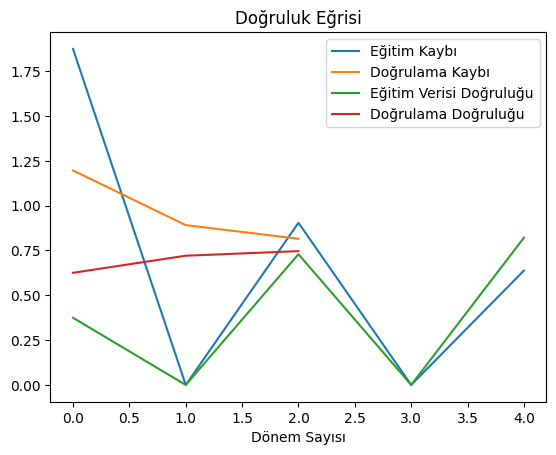

In [43]:
plot_loss_curves(resnet_tarih)

* Doğrulama kaybı, eğitim kadar hızlı düşmüyor.
* Model aşırı uymuş olabilir.
* Eğitim kayıpları azalırken doğrulama kaybı artmış.

In [38]:
# Resnet modeli özeti
resnet_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,626,272 (90.13 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 40,982 (160.09 KB)

Tek eğitilebilir parametre çıktı katmanıdır. Yani eğitilecek tek kalıp çıktı katmanımız, çünkü eğitilebilir bir şekilde ayarladık.

TensorFlow Hub'ın ne kadar faydalı olduğunu buradan görebilirsiniz. Özellik çıkarma katmanı, modelin ImageNet veri kümesinde zaten öğrendiği önceden öğrenilmiş desenler olan 23.564.800 parametreye sahiptir. Eğitilebilir=False ayarladığımız için, bu kalıplar eğitim sırasında donmuş (eğitilemez) kalır.

Bu, eğitim sırasında modelin veri kümemize uyacak şekilde çıkış katmanındaki 20.490 parametreyi güncellediği anlamına gelir.

### **2.6. Yeni bir model daha oluşturma**

In [51]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

IMAGE_SHAPE = (224, 224)  # Giriş görsel boyutları

def make_model(num_classes=10):
    """
    EfficientNetB0 modelini Keras üzerinden yükleyip, üzerine yeni bir Dense katman ekler.

    num_classes: (int) Çıkış katmanındaki sınıf sayısı.

    return: (tf.keras.Model) Derlenmemiş model.
    """
    # EfficientNetB0 modelini Keras üzerinden yükle
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Görselleri modelin beklediği şekilde ölçeklendir
    base_model.trainable = False  # Önceden eğitilmiş ağı dondur

    # Yeni model oluşturma
    model = models.Sequential([
        base_model,  # EfficientNetB0 taban katmanı
        layers.GlobalAveragePooling2D(),  # Global average pooling katmanı
        layers.Dense(num_classes, activation='softmax', name='output_layer')  # Son çıkış katmanı
    ])

    return model

# Modeli oluştur
efficient_model = make_model(num_classes=10)  # num_classes'ı eğitim verinizin sınıf sayısına göre ayarlayın

# Modeli derleme
efficient_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Modeli uydurma
efficient_tarih = efficient_model.fit(
    train_data_10_percent,  # Eğitim verisi
    epochs=5,  # Eğitim dönemi sayısı
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,  # Doğrulama verisi
    validation_steps=len(test_data),
    callbacks=[
        make_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="efficientnetB0")  # TensorBoard geri araması
    ]
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
TensorBoard günlük dosyalarının kaydedilmesi: tensorflow_hub/efficientnetB0/20241206-190853
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.0738 - loss: 2.3128 - val_accuracy: 0.1000 - val_loss: 2.3031
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 371ms/step - accuracy: 0.0955 - loss: 2.3058 - val_accuracy: 0.1000 - val_loss: 2.3031
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 347ms/step - accuracy: 0.1101 - loss: 2.3058 - val_accuracy: 0.1000 - val_loss: 2.3035


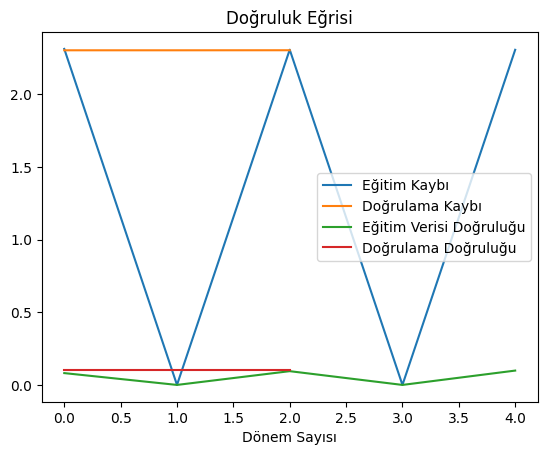

In [52]:
plot_loss_curves(efficient_tarih)

In [53]:
efficient_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,088,003 (15.59 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 25,622 (100.09 KB)

ResNet50V2 çıkarma katmanından dört kat daha az parametreye (4.049.564'e karşı 23.564.800) sahip olmasına rağmen, EfficientNetB0 özelliği çıkarma katmanı daha iyi performans sağlar. Şimdi "verimli" ismin nereden geldiği belli.

Callback ile model eğitim günlüklerimiz otomatik olarak izlendi.

# belki dönem sayısını arttırarak model performanslarını iyileştir...saçma sonuçların var...

# **3. Tensorboard**


Tensorboard: Ulaşım, makine öğrenimi modellerinizi, performansınızı ve dahili bilgilerinizi görsel olarak keşfetmenin bir yoludur ve TensorBoard.dev'de makine öğrenimi deneylerinizi barındırabilir, takip edebilir ve paylaşabilirsiniz. Ayrıca TensorBoard websiteleri ile entegre olabilir.

TensorBoard (Google Colab'a önceden yüklenmiş) gibi bir deney izleme aracının devreye girdiği yer burasıdır. https://www.tensorflow.org/tensorboard?hl=tr

İşin iyi yanı, bir TensorBoard geri araması kurduğumuz için, modelimizin tüm eğitim günlükleri otomatik olarak kaydedilmiştir. Bunları görselleştirmek için sonuçları TensorBoard.dev'e yükleyebiliriz. https://tensorboard.dev/

Sonuçlarınızı TensorBoard.dev'e yüklemek, birden fazla farklı modelleme deneyini izlemenizi ve paylaşmanızı sağlar. Bu nedenle, birine sonuçlarınızı göstermeniz gerekiyorsa, ona TensorBoard.dev'inizin yanı sıra beraberindeki Colab not defterine bir bağlantı gönderebilirsiniz.

🔑 Not: Bu deneyler halka açıktır, hassas veri yüklemeyin. Gerekirse deneyleri silebilirsiniz.

In [ ]:
# TensorBoard'a verileri yükleme
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Eğitim görüntülerinin %10'unu kullanarak iki farklı TF Hub özellik çıkarma modeli mimarisini karşılaştırma" \
  --one_shot # dosyaları yüklemeyi bitirdikten sonra, bir sefer yükleyiciden çıkarır

# Logdir hedef yükleme dizinidir
# Name deneyin adıdır
# Açıklama deneyin kısa bir açıklamasıdır

TensorBoad.dev'e her bir şey yüklediğinizde yeni bir deney kimliği alacaksınız. Deney kimliği şöyle görünecektir: https://tensorboard.dev/experiment/73taSKxXQeGPQsNBcVvY3g/ (bu, bu not defterindeki gerçek deneydir). https://tensorboard.dev/

Aynı dizini tekrar yüklerseniz, onunla birlikte gitmek için yeni bir deney kimliği alırsınız.

Bu, deneylerinizi izlemek anlamına gelir, yüklemelerinizi nasıl adlandırdığınıza bakmak isteyebilirsiniz. Bu şekilde onları TensorBoard.dev'de bulduğunuzda, her deney sırasında ne olduğunu anlayabilirsiniz (örn. "efficientnet0_10_percent_data").

In [ ]:
# Tensorboard'a hangi deneyleri yükledik?
!tensorboard dev list

In [ ]:
# Bir deney silmek için;
!tensorboard dev delete --experiment_id n6kd8XZ3Rdy1jSgSLH5WjA # daha önce yüklenmiş bir deneyin id'si

In [ ]:
# Ardından tekrar kontrol edebilirsiniz deney silidni mi diye
!tensorboard dev list

# **4. Kaynakça**

* TensorFlow Transfer Öğrenme Kılavuzunu okuyun ve ana iki transfer öğrenme türünü kendi kelimelerinizle tanımlayın.  https://www.tensorflow.org/tutorials/images/transfer_learning?hl=tr

* TensorFlow web sitesindeki TensorFlow Hub ile Transfer Learning öğreticisini gözden geçirin ve tüm kodu kendiniz yeni bir Google Colab not defterine yeniden yazın ve her adımın yol boyunca ne yaptığı hakkında yorumlar yapın.  https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub?hl=tr

* Bu dizüstü bilgisayarda TensorFlow Hub ile ince ayar yapmadık, ancak daha fazla bilgi edinmek istiyorsanız, TensorFlow ana sayfasında bir TensorFlow Hub modeli öğreticisini ince ayarlayın. Bir tensorflow hub modeli nasıl ince ayar yapılır:  https://www.tensorflow.org/hub/tf2_saved_model?hl=tr#fine-tuning

* Weights & Biases ile deney takibine bakın, bunu mevcut TensorBoard günlüklerimizle nasıl entegre edebilirsiniz?  https://wandb.ai/site/experiment-tracking

* https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb